In [1]:
# pip install segmentation-models

__To solve segmentation-model error:__
    
1. Go to `"./../anaconda3/Lib/site-packages/efficientnet/__init__.py"`
2. In the file change `keras.utils.generic_utils.get_custom_objects().update(custom_objects)` to `keras.utils.get_custom_objects().update(custom_objects)`

In [1]:
import sys
import gc
from PIL import Image
import tensorflow as tf
import keras
from keras import backend as K
import osgeo
import segmentation_models as sm

2024-04-27 18:43:41.383760: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 18:43:41.405429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 18:43:41.405445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 18:43:41.406119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 18:43:41.409931: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, Softmax
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.metrics import MeanIoU

## 1.

In [3]:
def load_data(images_dir:str, groundtruth_dir:None):
    images = []
    masks = []

    # Get all image files in the directory
    files = os.listdir(images_dir) # list
    img_files = [file for file in files if file.endswith('.tif')]  # only tif files
    
    for img_name in tqdm(img_files):
        img_pth = os.path.join(images_dir, img_name)
        
        # Load image
        image_data = gdal.Open(img_pth)
        img = image_data.ReadAsArray()  # shape (channels, X, Y); has 1 channel only
        
        # scale img to 0-1 range; normalizing each channels independently
        scaler = MinMaxScaler()
        num_channels = 1
        img = scaler.fit_transform(img.reshape(-1, num_channels)).reshape(img.shape) # each column represent a band
        
        images.append(img)
        
        
        if groundtruth_dir:
            mask_path = os.path.join(groundtruth_dir, img_name)
        
            # Load mask
            mask_data = gdal.Open(mask_path)
            mask = mask_data.ReadAsArray()  # shape (channels, X, Y)
            mask = mask.transpose(1,2,0) # shape (X, Y, channels)
            
            # Set values less than 200 to 0 and greater than 200 to 255; as one label has many values b/w 0-255
            mask[mask <= 200] = 0
            mask[mask > 200] = 255

            masks.append(mask)
        
    print(f"Images count: {len(images)} & Masks count: {len(masks)}")
    print('Images are Normalized and Masks are not !')

    print()
    # to get the shape of all images and masks
    if groundtruth_dir:
        print('Each Image & its corresponding mask size : ')
        for i,m in zip(images, masks):
            print(i.shape, m.shape)

    else:
        print('Each Image size : ')
        for i in images:
            print(i.shape)
            
    print()
        
    return images, masks, img_files

100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 43.91it/s]


Images count: 28 & Masks count: 28
Images are Normalized and Masks are not !

Each Image & its corresponding mask size : 
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)
(1024, 1024) (1024, 1024, 3)

Shape : (1024, 1024) (1024, 1024, 3)


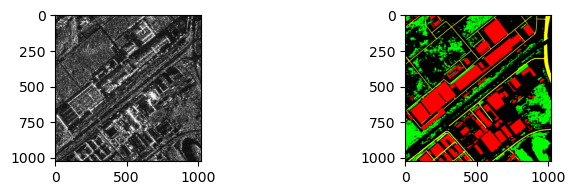

In [4]:
# train dataset folder
data_dir = "./assignment3DataUpload/"
train_images_dir = data_dir + 'trainingImagesAndLabels/' + "Images/"
train_groundtruth_dir = data_dir + 'trainingImagesAndLabels/' + "Labels/"

# train set
train_images, train_masks,_ = load_data(train_images_dir, train_groundtruth_dir)

idx = random.randint(0, len(train_images))
print(f'Shape :', train_images[idx].shape, train_masks[idx].shape)

# Plot for image
plt.subplot(1, 3, 1)
plt.imshow(train_images[idx], cmap='gray')
# Plot for label
plt.subplot(1, 3, 3)
plt.imshow(train_masks[idx])
plt.show()

In [6]:
# patches extraction

# creating overlap patches and which makes train data larger
def extract_patches(images:list, masks:list, patch_size=(256, 256), stride=1): 
    image_patches = []
    mask_patches = []

    for i in tqdm(range(len(images))):
        img = images[i]
        mask = masks[i]
        height, width = img.shape

        for y in range(0, height - patch_size[0] + 1, stride):
            for x in range(0, width - patch_size[1] + 1, stride):
                image_patch = img[y:y + patch_size[0], x:x + patch_size[1]]
                mask_patch = mask[y:y + patch_size[0], x:x + patch_size[1], :]

                image_patches.append(image_patch)
                mask_patches.append(mask_patch)
    
    return np.array(image_patches), np.array(mask_patches)

# train set:
patch_size = (256, 256)
stride = 80
train_image_patches, train_mask_patches = extract_patches(train_images, train_masks, patch_size, stride)
print("Image patches shape:", train_image_patches.shape)
print("Mask patches shape:", train_mask_patches.shape) 

100%|████████████████████████████████████████| 28/28 [00:00<00:00, 14350.01it/s]


Image patches shape: (2800, 256, 256)
Mask patches shape: (2800, 256, 256, 3)


In [7]:
train_image_patches.max(), train_image_patches.min()

(1.0, 0.0)

In [8]:
train_mask_patches.max(), train_mask_patches.min()

(255, 0)

In [9]:
# To find unique values of each all pixels in all images
unique_values = np.unique(train_mask_patches.reshape(-1, 3), axis=0) # Reshape to 2D array;  find the unique rows (unique pixel values) - a pixel with 3 channels
print(len(unique_values))
print(unique_values)

4
[[  0   0   0]
 [  0 255   0]
 [255   0   0]
 [255 255   0]]


In [10]:
def rgb_to_label(image_mask):
    """
    Convert 3D- RGB label masks to 2D label masks.
    """
    # below is the RGB to integer label
    C0 = np.array([0,0,0]) # unseen; black
    C1 = np.array([255, 0, 0])  # red
    C2 = np.array([0, 255, 0]) # green
    C3 = np.array([255, 255, 0]) # yellow
    
    # integer label
    label_seg = np.zeros(image_mask.shape[:2], dtype=np.uint8)
    label_seg[np.all(image_mask == C1, axis=-1)] = 0
    label_seg[np.all(image_mask == C2, axis=-1)] = 1
    label_seg[np.all(image_mask == C3, axis=-1)] = 2
    label_seg[np.all(image_mask == C0, axis=-1)] = 3
    
    return label_seg

In [12]:
# Train labels
train_labels = []
for i in tqdm(range(train_mask_patches.shape[0])):
    label = rgb_to_label(train_mask_patches[i])
    train_labels.append(label)
    
train_labels = np.array(train_labels)
print(train_labels.shape)
print('Total unique classes : ', len(np.unique(train_labels)))
print('Class Labels : ', np.unique(train_labels))

100%|██████████████████████████████████████| 2800/2800 [00:08<00:00, 333.07it/s]


(2800, 256, 256)
Total unique classes :  4
Class Labels :  [0 1 2 3]


In [13]:
train_labels = np.expand_dims(train_labels, axis=3)
print(train_labels.shape)

(2800, 256, 256, 1)


In [14]:
n_classes = len(np.unique(train_labels))
train_labels_cat = to_categorical(train_labels, num_classes=n_classes) # this gives one-hot in order refer to documentation
# Note: The input labels has to be in number form and value from 0 to num_class-1.
print(train_labels_cat.shape)

(2800, 256, 256, 4)


In [15]:
# slice the array to have 3 dimension for each one-hot vector. As there are 3 actual class
train_labels_cat = train_labels_cat[:, :, :, :3]

# find the pixels with [0,0,0] values i.e unknown class
zero_pixels = np.all(train_labels_cat == [0, 0, 0], axis=-1)

# Replace label for unknown class with [1,1,1] i.e it belongs to all class
train_labels_cat[zero_pixels] = [0.33, 0.33, 0.33] # assign equal probabilities to each class
print(train_labels_cat.shape)

# unique_pixels = np.unique(train_labels_cat.reshape(-1, 3), axis=0)

# for pixel in unique_pixels:
#     print(f"Pixel: {pixel}")

(2800, 256, 256, 3)


In [16]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(np.expand_dims(train_image_patches, axis=-1), train_labels_cat, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(2240, 256, 256, 1) (2240, 256, 256, 3)
(560, 256, 256, 1) (560, 256, 256, 3)


In [17]:
del train_images, train_masks, train_image_patches, train_mask_patches, train_labels_cat, train_labels
gc.collect()
K.clear_session()

In [17]:
def model_train_pipeline(X_train, y_train, X_valid, y_valid, BACKBONE = 'resnet34', epochs = 100):
    preprocess_input = sm.get_preprocessing(BACKBONE)

    # preprocess input
    X_train = preprocess_input(X_train)
    print(X_train.shape, y_train.shape)
    
    IMG_HEIGHT = X_train.shape[1]
    IMG_WIDTH  = X_train.shape[2]
    IMG_CHANNELS = X_train.shape[3]

    n_classes = y_train.shape[3]

    # define model;  encoder_freeze=False i.e training Encoder with imagenet as initial weights o/w Fine tuning if True 
    base_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes= n_classes, activation='softmax',
                   encoder_freeze=False, decoder_filters=(256, 128, 64, 32, 16), decoder_use_batchnorm=True)

    inp = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model = Model(inp, out, name=base_model.name)

    # based on this i have manually put the class weightage which sums to one; i can also take from the above one
    class_weights = [0.22,0.16,0.4] # If some class has a weight of 0.00, it means that the model will not consider that class during the calculation of the loss function.
    
    #Define loss, metrics and optimizer to be used for training
    dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)  
    
    metrics = ['accuracy', sm.metrics.IOUScore(class_weights=class_weights)]
    
    lr = 0.0001
    optim = keras.optimizers.Adam(lr)

    model.compile(optimizer=optim, loss= total_loss, metrics=metrics)
    
    
    model_checkpoint_folder = './model_checkpoint/'
    os.makedirs(model_checkpoint_folder, exist_ok = True)

    filename = f'train_{BACKBONE}.hdf5'
    print('Model will be saved in directory : ', model_checkpoint_folder)
    fname = os.path.join(model_checkpoint_folder, filename)

    # Set callback functions to early stop training and save the best model so far; `iou_score` is the above defined metric name
    callbacks = [ModelCheckpoint(filepath = fname, monitor = 'iou_score', mode='max', save_best_only = True, verbose = 1)]#,lrate_scheduler                         


    history = model.fit(X_train, y_train, 
                        batch_size = 16,
                        validation_data = (X_valid, y_valid),
                        verbose=1, 
                        epochs=epochs, 
                        shuffle=True,
                       callbacks = callbacks)

    return fname, history

In [18]:
def acc_loss_plot(history):
    # Set the size of the figure
    plt.figure(figsize=(12, 4)) 

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation IoU
    plt.subplot(1, 2, 2)
    acc = history.history['iou_score']
    val_acc = history.history['val_iou_score']
    plt.plot(epochs, acc, 'y', label='Training IoU')
    plt.plot(epochs, val_acc, 'r', label='Validation IoU')
    plt.title('Training and validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.show()

### Pre-trained model

In [17]:
BACKBONE = 'seresnet34'
epochs = 200
fname_ser34, history_ser34 = model_train_pipeline(X_train, y_train, X_valid, y_valid, BACKBONE = BACKBONE, epochs = epochs)

(2240, 256, 256, 1) (2240, 256, 256, 3)


2024-04-26 21:29:35.625295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 21:29:35.643606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 21:29:35.643753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model will be saved in directory :  ./model_checkpoint/
Epoch 1/200


2024-04-26 21:29:45.102260: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-26 21:29:45.111870: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-26 21:29:45.173395: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-26 21:29:49.149070: I external/local_xla/xla/service/service.cc:168] XLA service 0x78a9a83df860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-26 21:29:49.149092: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-04-26 21:29:49.151855: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714147189.204394   96174 device_compiler.

140/140 [==============================] - ETA: 0s - loss: 0.9514 - accuracy: 0.4850 - iou_score: 0.0553
Epoch 1: iou_score improved from -inf to 0.05530, saving model to ./model_checkpoint/train_seresnet34.hdf5


/home/kshitij/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 40s 121ms/step - loss: 0.9514 - accuracy: 0.4850 - iou_score: 0.0553 - val_loss: 0.9655 - val_accuracy: 0.5508 - val_iou_score: 0.0482
Epoch 2/200
140/140 [==============================] - ETA: 0s - loss: 0.9381 - accuracy: 0.5070 - iou_score: 0.0640
Epoch 2: iou_score improved from 0.05530 to 0.06401, saving model to ./model_checkpoint/train_seresnet34.hdf5
140/140 [==============================] - 14s 97ms/step - loss: 0.9381 - accuracy: 0.5070 - iou_score: 0.0640 - val_loss: 0.9644 - val_accuracy: 0.6927 - val_iou_score: 0.0476
Epoch 3/200
140/140 [==============================] - ETA: 0s - loss: 0.9317 - accuracy: 0.5152 - iou_score: 0.0686
Epoch 3: iou_score improved from 0.06401 to 0.06856, saving model to ./model_checkpoint/train_seresnet34.hdf5
140/140 [==============================] - 14s 97ms/step - loss: 0.9317 - accuracy: 0.5152 - iou_score: 0.0686 - val_loss: 0.9871 - val_accuracy: 0.6964 - val_iou_score: 0.0439
Epoch 4/200
14

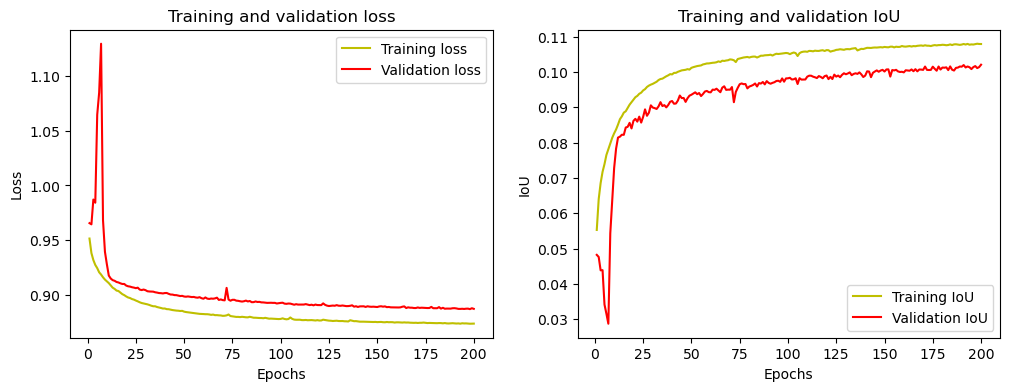

In [18]:
acc_loss_plot(history_ser34)

### From Scratch

In [19]:
# Define U-Net model with batch normalization
def unet_model(IMG_HEIGHT=224, IMG_WIDTH=224, IMG_CHANNELS=1, n_classes=1, kernel_initializer = 'he_normal', 
              kernel_regularizer=tf.keras.regularizers.l1(), activation='relu'):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Downsample
    c1 = Conv2D(16, (3, 3), activation=activation, kernel_initializer= kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.4)(c1) 
    c1 = Conv2D(16, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.3)(c2) 
    c2 = Conv2D(32, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.5)(c4)
    c4 = Conv2D(128, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(c5)
    c5 = BatchNormalization()(c5)
    
    # UPSample 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.5)(c6)
    c6 = Conv2D(128, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(c6)
    c6 = BatchNormalization()(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(c7)
    c7 = BatchNormalization()(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(32, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(c8)
    c8 = BatchNormalization()(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.4)(c9)
    c9 = Conv2D(16, (3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same', kernel_regularizer = kernel_regularizer)(c9)
    c9 = BatchNormalization()(c9)
     
    logits = Conv2D(n_classes, (1, 1))(c9) # No activation function
    outputs = Softmax()(logits) # Add a separate layer for softmax
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [20]:
def train_scratch(X_train, y_train, X_valid, y_valid, model, model_name):
    #Define loss, metrics and optimizer to be used for training
    class_weights = [0.22,0.16,0.4] # If some class has a weight of 0.00, it means that the model will not consider that class during the calculation of the loss function.
    dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)  

    metrics = ['accuracy', sm.metrics.IOUScore(class_weights=class_weights)]

    lr = 0.001
    optim = keras.optimizers.Adam(lr)

    model.compile(optimizer=optim, loss= total_loss, metrics=metrics)
    
    model_checkpoint_folder = './model_checkpoint/'
    os.makedirs(model_checkpoint_folder, exist_ok = True)

    filename = f'train_scratch_{model_name}.hdf5'
    print('Model will be saved in directory : ', model_checkpoint_folder)
    fname_scratch = os.path.join(model_checkpoint_folder, filename)

    # Set callback functions to early stop training and save the best model so far
    callbacks = [ModelCheckpoint(filepath = fname_scratch, monitor = 'iou_score', mode='max', save_best_only = True, verbose = 1)]#,lrate_scheduler                         


    history_scratch = model.fit(X_train, y_train, 
                        batch_size = 16,
                        validation_data = (X_valid, y_valid),
                        verbose=1, 
                        epochs=200, 
                        shuffle=True,
                       callbacks = callbacks)
    
    return fname_scratch, history_scratch
    

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

n_classes = y_train.shape[3]

print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes)

256 256 1 3


In [21]:
model_name = 'model1'
model1 = unet_model(IMG_HEIGHT=IMG_HEIGHT , IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS, n_classes=n_classes, kernel_initializer = 'he_normal', 
              kernel_regularizer=tf.keras.regularizers.l1(), activation='relu')

fname_model1, history_model1 = train_scratch(X_train, y_train, X_valid, y_valid, model1, model_name)

2024-04-26 22:38:11.718947: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 22:38:11.737622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-26 22:38:11.737752: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model will be saved in directory :  ./model_checkpoint/
Epoch 1/200


2024-04-26 22:38:15.954739: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-26 22:38:16.372721: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-26 22:38:16.420654: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-26 22:38:16.475413: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-26 22:38:18.195948: I external/local_xla/xla/service/service.cc:168] XLA service 0x72be863eddf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-26 22:38:18.195962: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, C

140/140 [==============================] - ETA: 0s - loss: 112.7924 - accuracy: 0.3418 - iou_score: 0.0487
Epoch 1: iou_score improved from -inf to 0.04872, saving model to ./model_checkpoint/train_scratch_model1.hdf5
140/140 [==============================] - 24s 89ms/step - loss: 112.7924 - accuracy: 0.3418 - iou_score: 0.0487 - val_loss: 5.8861 - val_accuracy: 0.2357 - val_iou_score: 0.0483
Epoch 2/200
  1/140 [..............................] - ETA: 10s - loss: 5.8860 - accuracy: 0.2563 - iou_score: 0.0499

/home/kshitij/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - ETA: 0s - loss: 3.8543 - accuracy: 0.2542 - iou_score: 0.0486
Epoch 2: iou_score did not improve from 0.04872
140/140 [==============================] - 11s 79ms/step - loss: 3.8543 - accuracy: 0.2542 - iou_score: 0.0486 - val_loss: 3.2980 - val_accuracy: 0.2357 - val_iou_score: 0.0483
Epoch 3/200
140/140 [==============================] - ETA: 0s - loss: 3.2491 - accuracy: 0.2349 - iou_score: 0.0483
Epoch 3: iou_score did not improve from 0.04872
140/140 [==============================] - 11s 78ms/step - loss: 3.2491 - accuracy: 0.2349 - iou_score: 0.0483 - val_loss: 3.2000 - val_accuracy: 0.2357 - val_iou_score: 0.0483
Epoch 4/200
140/140 [==============================] - ETA: 0s - loss: 3.1697 - accuracy: 0.2349 - iou_score: 0.0483
Epoch 4: iou_score did not improve from 0.04872
140/140 [==============================] - 11s 78ms/step - loss: 3.1697 - accuracy: 0.2349 - iou_score: 0.0483 - val_loss: 3.1301 - val_accuracy: 0.2357 - val_iou_

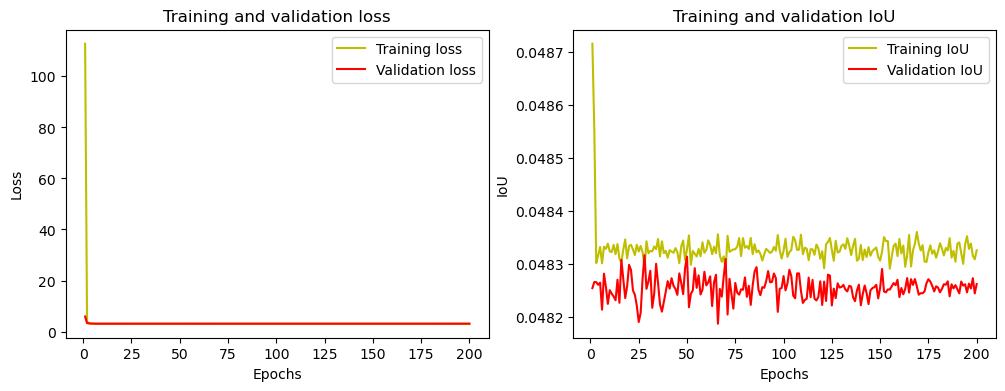

In [22]:
acc_loss_plot(history_model1)

In [23]:
model_name = 'model2'
model2 = unet_model(IMG_HEIGHT=IMG_HEIGHT , IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS, n_classes=n_classes, kernel_initializer = 'he_normal', 
              kernel_regularizer=tf.keras.regularizers.l1_l2(), activation='relu')

fname_model2, history_model2 = train_scratch(X_train, y_train, X_valid, y_valid, model2, model_name)

Model will be saved in directory :  ./model_checkpoint/
Epoch 1/200


2024-04-26 23:16:40.117811: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 [==============================] - ETA: 0s - loss: 119.0545 - accuracy: 0.3482 - iou_score: 0.0497
Epoch 1: iou_score improved from -inf to 0.04968, saving model to ./model_checkpoint/train_scratch_model2.hdf5
140/140 [==============================] - 17s 89ms/step - loss: 119.0545 - accuracy: 0.3482 - iou_score: 0.0497 - val_loss: 6.4594 - val_accuracy: 0.1501 - val_iou_score: 0.0484
Epoch 2/200
140/140 [==============================] - ETA: 0s - loss: 4.1638 - accuracy: 0.3510 - iou_score: 0.0488
Epoch 2: iou_score did not improve from 0.04968
140/140 [==============================] - 12s 84ms/step - loss: 4.1638 - accuracy: 0.3510 - iou_score: 0.0488 - val_loss: 3.4295 - val_accuracy: 0.2357 - val_iou_score: 0.0484
Epoch 3/200
140/140 [==============================] - ETA: 0s - loss: 3.3461 - accuracy: 0.2464 - iou_score: 0.0484
Epoch 3: iou_score did not improve from 0.04968
140/140 [==============================] - 12s 84ms/step - loss: 3.3461 - accuracy: 0.2464 - iou

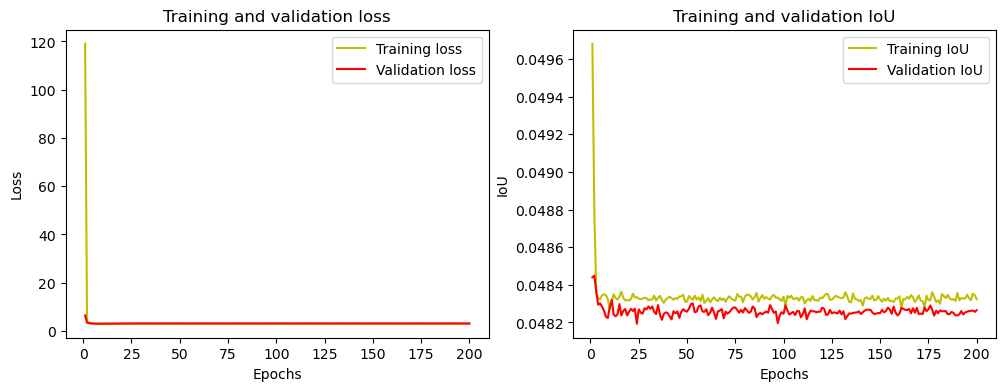

In [24]:
acc_loss_plot(history_model2)

In [25]:
model_name = 'model3'
model3 = unet_model(IMG_HEIGHT=IMG_HEIGHT , IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS, n_classes=n_classes, kernel_initializer = 'glorot_uniform', 
              kernel_regularizer=tf.keras.regularizers.l2(), activation='tanh')

fname_model3, history_model3 = train_scratch(X_train, y_train, X_valid, y_valid, model3, model_name)

Model will be saved in directory :  ./model_checkpoint/
Epoch 1/200


2024-04-26 23:56:05.164038: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 [==============================] - ETA: 0s - loss: 2.5860 - accuracy: 0.4148 - iou_score: 0.0502
Epoch 1: iou_score improved from -inf to 0.05019, saving model to ./model_checkpoint/train_scratch_model3.hdf5
140/140 [==============================] - 20s 100ms/step - loss: 2.5860 - accuracy: 0.4148 - iou_score: 0.0502 - val_loss: 1.0061 - val_accuracy: 0.2357 - val_iou_score: 0.0483
Epoch 2/200
140/140 [==============================] - ETA: 0s - loss: 0.9768 - accuracy: 0.4591 - iou_score: 0.0502
Epoch 2: iou_score improved from 0.05019 to 0.05024, saving model to ./model_checkpoint/train_scratch_model3.hdf5
140/140 [==============================] - 12s 86ms/step - loss: 0.9768 - accuracy: 0.4591 - iou_score: 0.0502 - val_loss: 0.9778 - val_accuracy: 0.0654 - val_iou_score: 0.0485
Epoch 3/200
140/140 [==============================] - ETA: 0s - loss: 0.9754 - accuracy: 0.4662 - iou_score: 0.0505
Epoch 3: iou_score improved from 0.05024 to 0.05048, saving model to ./model_chec

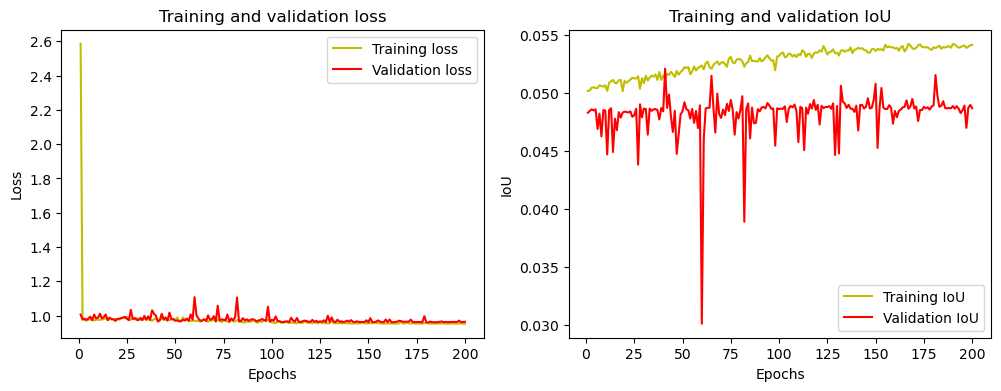

In [26]:
acc_loss_plot(history_model3)

In [27]:
model_name = 'model4'
model4 = unet_model(IMG_HEIGHT=IMG_HEIGHT , IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS, n_classes=n_classes, kernel_initializer = 'orthogonal', 
              kernel_regularizer=tf.keras.regularizers.l1_l2(), activation=tf.keras.layers.LeakyReLU())

fname_model4, history_model4 = train_scratch(X_train, y_train, X_valid, y_valid, model4, model_name)

Model will be saved in directory :  ./model_checkpoint/
Epoch 1/200


2024-04-27 00:35:34.319080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_27/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 [==============================] - ETA: 0s - loss: 62.3084 - accuracy: 0.3866 - iou_score: 0.0503
Epoch 1: iou_score improved from -inf to 0.05029, saving model to ./model_checkpoint/train_scratch_model4.hdf5
140/140 [==============================] - 17s 87ms/step - loss: 62.3084 - accuracy: 0.3866 - iou_score: 0.0503 - val_loss: 3.8608 - val_accuracy: 0.6989 - val_iou_score: 0.0484
Epoch 2/200
140/140 [==============================] - ETA: 0s - loss: 3.2501 - accuracy: 0.3336 - iou_score: 0.0488
Epoch 2: iou_score did not improve from 0.05029
140/140 [==============================] - 11s 82ms/step - loss: 3.2501 - accuracy: 0.3336 - iou_score: 0.0488 - val_loss: 3.0510 - val_accuracy: 0.6989 - val_iou_score: 0.0484
Epoch 3/200
140/140 [==============================] - ETA: 0s - loss: 3.0141 - accuracy: 0.2626 - iou_score: 0.0484
Epoch 3: iou_score did not improve from 0.05029
140/140 [==============================] - 12s 83ms/step - loss: 3.0141 - accuracy: 0.2626 - iou_s

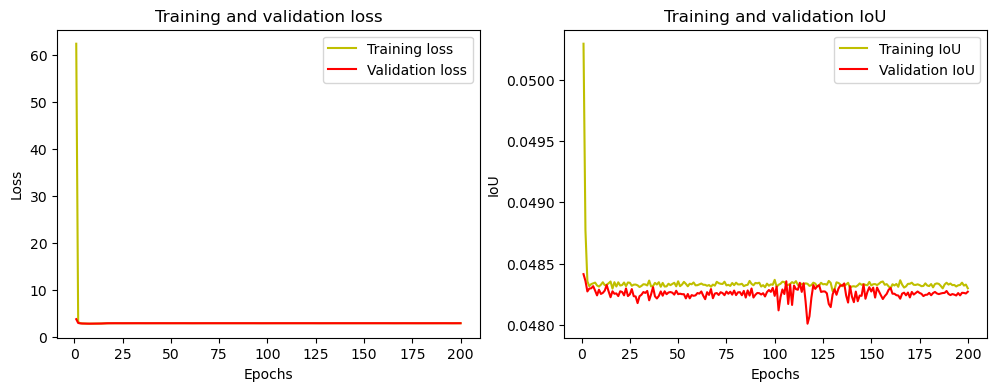

In [28]:
acc_loss_plot(history_model4)

### Temperature Scaling

In [16]:
def temperature_scaling(y_logits, y_valid):
    temp = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32, name="temp")

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    for epoch in range(500):
        with tf.GradientTape() as tape:
            scaled_logits = y_logits / temp
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_valid, logits=scaled_logits))
            gradients = tape.gradient(loss, [temp])
        
        optimizer.apply_gradients(zip(gradients, [temp]))
        
        if epoch % 100 == 0:
            print("Epoch:", (epoch + 1), "Loss =", "{:.15f}".format(loss.numpy()), "Temperature =", temp.numpy())
    
    return temp.numpy()

In [17]:
def best_temp(models: dict, X_valid, y_valid):
    temps = []
    
    for name, base_model in models.items(): # base_model is with softmax
        if name == 'seresnet34':
            # preprocess input
            preprocess_input = sm.get_preprocessing('seresnet34') # if in the models list we also use pre-trained model here seresnet
            X_valid = preprocess_input(X_valid)


        logits_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
        y_logits = logits_model.predict(X_valid, verbose=0)  # logits: shape (bs, height, width, num_classes)
        
        final_temp_value = temperature_scaling(y_logits, y_valid)
        temps.append(final_temp_value)
        
    return temps

In [4]:
## Load each models as logits generating
model_ser34 = tf.keras.models.load_model('./model_checkpoint/train_seresnet34.hdf5', compile = False)

model_1 = tf.keras.models.load_model('./model_checkpoint/train_scratch_model1.hdf5', compile = False)
model_2 = tf.keras.models.load_model('./model_checkpoint/train_scratch_model2.hdf5', compile = False)
model_3 = tf.keras.models.load_model('./model_checkpoint/train_scratch_model3.hdf5', compile = False)
model_4 = tf.keras.models.load_model('./model_checkpoint/train_scratch_model4.hdf5', compile = False)

models = {'seresnet34': model_ser34, 'model1': model_1, 'model2': model_2, 'model3': model_3, 'model4': model_4}
del model_ser34, model_1 , model_2, model_3, model_4

# models = {'seresnet34': model_ser34}#, 'model1': model_1, 'model3': model_3}
# del model_ser34#, model_1 , model_3
gc.collect()
K.clear_session()

2024-04-27 17:22:14.702672: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 17:22:14.721541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 17:22:14.721647: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
# final T
temps = best_temp(models, X_valid, y_valid)

2024-04-27 12:57:56.202936: I external/local_xla/xla/service/service.cc:168] XLA service 0x214219f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-27 12:57:56.202951: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-04-27 12:57:56.211475: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-27 12:57:56.231401: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1714202876.279555   16803 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 1 Loss = 1.114474296569824 Temperature = 1.0099989
Epoch: 101 Loss = 1.103021144866943 Temperature = 1.7509948
Epoch: 201 Loss = 1.100400567054749 Temperature = 2.2066998
Epoch: 301 Loss = 1.099089860916138 Temperature = 2.5696754
Epoch: 401 Loss = 1.098266124725342 Temperature = 2.8830705


2024-04-27 12:59:28.131601: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch: 1 Loss = 1.082555055618286 Temperature = 0.9900038
Epoch: 101 Loss = 1.073353528976440 Temperature = 0.30938467
Epoch: 201 Loss = 1.073351621627808 Temperature = 0.314061
Epoch: 301 Loss = 1.073351144790649 Temperature = 0.31409362
Epoch: 401 Loss = 1.073351144790649 Temperature = 0.3140936
Epoch: 1 Loss = 1.096094131469727 Temperature = 1.0099934
Epoch: 101 Loss = 1.094278812408447 Temperature = 1.7369868
Epoch: 201 Loss = 1.093888878822327 Temperature = 2.172243
Epoch: 301 Loss = 1.093696951866150 Temperature = 2.5156617
Epoch: 401 Loss = 1.093577742576599 Temperature = 2.81039
Epoch: 1 Loss = 1.141529679298401 Temperature = 1.0099995
Epoch: 101 Loss = 1.114646315574646 Temperature = 1.7420874
Epoch: 201 Loss = 1.108806014060974 Temperature = 2.1843011
Epoch: 301 Loss = 1.105933308601379 Temperature = 2.5342062
Epoch: 401 Loss = 1.104147434234619 Temperature = 2.8350496
Epoch: 1 Loss = 1.089643836021423 Temperature = 0.9900109
Epoch: 101 Loss = 1.085743546485901 Temperature = 

In [20]:
temps

[3.1619246, 0.3140936, 3.071475, 3.101913, 0.24277015]

In [4]:
temps = [3.1619246, 0.3140936, 3.071475, 3.101913, 0.24277015]

### Testing

In [3]:
# Set TensorFlow to use CPU
tf.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'), 'CPU')  # Set CPU as visible device

2024-04-27 13:39:17.259343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 13:39:17.383842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 13:39:17.383950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
## Load each models as logits generating
model_ser34 = tf.keras.models.load_model('./model_checkpoint/train_seresnet34.hdf5', compile = False)
model_ser34 = Model(inputs=model_ser34.input, outputs=model_ser34.layers[-2].output)

model_1 = tf.keras.models.load_model('./model_checkpoint/train_scratch_model1.hdf5', compile = False)
model_1 = Model(inputs=model_1.input, outputs=model_1.layers[-2].output)
model_2 = tf.keras.models.load_model('./model_checkpoint/train_scratch_model2.hdf5', compile = False)
model_2 = Model(inputs=model_2.input, outputs=model_2.layers[-2].output)
model_3 = tf.keras.models.load_model('./model_checkpoint/train_scratch_model3.hdf5', compile = False)
model_3 = Model(inputs=model_3.input, outputs=model_3.layers[-2].output)
model_4 = tf.keras.models.load_model('./model_checkpoint/train_scratch_model4.hdf5', compile = False)
model_4 = Model(inputs=model_4.input, outputs=model_4.layers[-2].output)

models = {'seresnet34': model_ser34, 'model1': model_1, 'model2': model_2, 'model3': model_3, 'model4': model_4}
del model_ser34, model_1 , model_2, model_3, model_4

# models = {'seresnet34': model_ser34}#, 'model1': model_1, 'model3': model_3}
# del model_ser34#, model_1 , model_3
gc.collect()
K.clear_session()

2024-04-27 18:44:18.656286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 18:44:18.675649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 18:44:18.675753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
def assign_labels(softmax_scores_list, threshold=0.005):
    assigned_labels_list = []
    
    # Step 1: Assign labels based on maximum score difference from 2nd max score for each model
    for softmax_scores in softmax_scores_list:
        max_indices = np.argmax(softmax_scores, axis=-1)
        max_values = np.max(softmax_scores, axis=-1)
        
        sorted_scores = np.sort(softmax_scores, axis=-1)
        second_max_values = sorted_scores[..., -2]
        
        labels = np.where(max_values - second_max_values > threshold, max_indices.squeeze(), -1) # -1 is label for 'OOD'
        assigned_labels_list.append(labels)
    
    # Step 2: Find class with maximum repetition for each pixel
    assigned_labels_list = np.stack(assigned_labels_list, axis=-1)
    assigned_labels_list = np.squeeze(assigned_labels_list, axis=0)  # Remove the batch dimension
    
    # Step 2: Find class with maximum repetition for each pixel
    final_labels = np.zeros((assigned_labels_list.shape[0], assigned_labels_list.shape[1], 1), dtype=np.int8) # np.int8 as -1 label is there so no np.uint8
    
    # Iterate through each pixel
    for row in range(assigned_labels_list.shape[0]):
        for col in range(assigned_labels_list.shape[1]):
            pixel_labels = assigned_labels_list[row, col]
            unique_labels, label_counts = np.unique(pixel_labels, return_counts=True)
            
            # If all labels are different, assign 'OOD'
            if len(np.unique(label_counts)) == 1:
                final_labels[row, col, 0] = -1 # -1 is label for 'OOD'
                
            else:
                # Majority voting
                majority_label = unique_labels[np.argmax(label_counts)]
                final_labels[row, col, 0] = majority_label
    
    return np.array(final_labels)

In [7]:
def test_prediction(models:dict, images:list, temps : list, patch_size=(256, 256)): 
    # Order of models and temps should be same
    pred_labels = []

    # if in the models list we also use pre-trained model here seresnet
    preprocess_input = sm.get_preprocessing('seresnet34')
    
    for i in tqdm(range(len(images))):
        img = images[i] # each image is of size (height, width, channels)
        label_seg = np.zeros((img.shape[0], img.shape[1]), dtype=np.int8)
        height, width, _ = img.shape
        
        if height % patch_size[0] == 0: # say height = 448 and patch_size = (224,224)
            height_pixels = [i for i in range(0, height - patch_size[0] + 1, patch_size[0])] # then = [0, 224]

        else: # say height = 449
            height_pixels = [i for i in range(0, height + 1, patch_size[0])] # then = [0, 224, 448]


        if width % patch_size[1] == 0: # slly
            width_pixels = [i for i in range(0, width - patch_size[1] + 1, patch_size[1])]

        else: # say height = 449
            width_pixels = [i for i in range(0, width + 1, patch_size[1])]
            

        for y in height_pixels:
            for x in width_pixels:
                x1 = x
                y1 = y

                y2 = y1 + patch_size[0]
                x2 = x1 + patch_size[1]

                if width % patch_size[1] != 0 and x == width_pixels[-1]: # if not multiple of patch size & x is the last element
                    # then take patch from last-patch_size to last pixel
                    x1 = width - patch_size[1]
                    x2 = width

                    width_rem = width - x # difference between last pixel in image and last element in width_pixels

                if height % patch_size[0] != 0 and y == height_pixels[-1]: # if not multiple of patch size& y is the last element
                    # then take patch from last-patch_size to last pixel
                    y1 = height - patch_size[0]
                    y2 = height

                    height_rem = height - y # slly


                image_patch = img[y1:y2, x1:x2, :]

                image_patch = np.expand_dims(image_patch, 0) # to shape (1, height, width, channels)

                softmax_scores_list = []
                for index, (name, logits_model) in enumerate(models.items()): # base_model is with softmax
                    if name == 'seresnet34':
                        # preprocess input
                        image_patch = preprocess_input(image_patch)


                    # logits_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
                    y_logits = logits_model.predict(image_patch, verbose=0)  # logits: shape (1, height, width, num_classes)
                    y_logits_temp = np.divide(y_logits, temps[index]) # logits after dividing with final temperature, temp
                    # Apply softmax activation
                    y_pred = tf.nn.softmax(tf.convert_to_tensor(y_logits_temp)).numpy() # shape (1, height, width, num_classes)

                    softmax_scores_list.append(y_pred)

                    del logits_model
                    gc.collect()
                    K.clear_session()
                    
                final_labels = assign_labels(softmax_scores_list) # shape (height, width, 1)
                final_labels = np.squeeze(final_labels, axis=-1) # shape (height, width)
                # this will have the class integer name

                x1p = 0
                y1p = 0
                if width % patch_size[1] != 0 and x == width_pixels[-1]:
                    x1p = -width_rem

                if height % patch_size[0] != 0 and y == height_pixels[-1]:
                    y1p = - height_rem


                label_seg[y:y + patch_size[0], x:x + patch_size[1]] = final_labels[y1p:,x1p:]

        pred_labels.append(label_seg)

    return pred_labels

In [8]:
# for test set prediction
def test_pipeline(models, temps, test_images):
    # test set prediction: this will have class label number
    patch_size = (256, 256)

    # Input images has to be a list with each image having shape : (height, width, channels)
    test_pred_labels = test_prediction(models, test_images, temps, patch_size)
    print("Test set prediction labels length :", len(test_pred_labels))
    print('Shape of one mask label : ', test_pred_labels[0].shape)

    return test_pred_labels

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 238.99it/s]

Images count: 10 & Masks count: 0
Images are Normalized and Masks are not !

Each Image size : 
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)

Shape : (1024, 1024, 1)


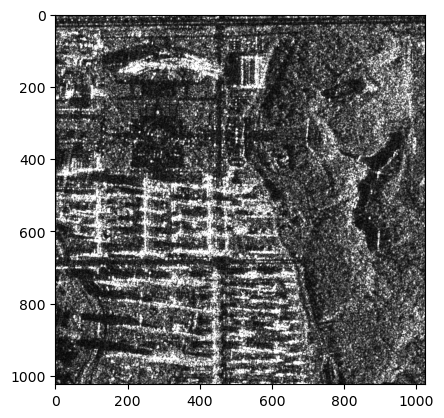

In [9]:
# test dataset folder
data_dir = "./assignment3DataUpload/"
test_images_dir = data_dir + 'testImages/'

test_images, _, test_img_files = load_data(test_images_dir, None)
test_images = np.expand_dims(test_images, axis=-1)

idx = random.randint(0, len(test_images)-1)
print(f'Shape :', test_images[idx].shape)

# Plot for image
plt.imshow(test_images[idx], cmap='gray')
plt.show()

In [10]:
test_pred_labels = test_pipeline(models, temps, test_images)
test_pred_labels[0]

  0%|                                                    | 0/10 [00:00<?, ?it/s]2024-04-27 18:44:30.912350: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-27 18:44:30.955531: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


100%|███████████████████████████████████████████| 10/10 [03:08<00:00, 18.85s/it]

Test set prediction labels length : 10
Shape of one mask label :  (1024, 1024)


array([[ 2,  2,  2, ..., -1, -1, -1],
       [ 2,  2,  2, ..., -1, -1, -1],
       [ 2,  2,  2, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1,  2, ..., -1, -1, -1],
       [-1, -1,  2, ...,  2,  2, -1]], dtype=int8)

In [11]:
def label_to_rgb(label_mask):
    """
    Convert 2D label masks back to RGB masks.
    """
    # RGB values corresponding to each class label
    colors = {
        0: [255, 0, 0],      # Class 0
        1: [0, 255, 0],    # Class 1
        2: [255, 255, 0],   # Class 2
        -1: [0 , 0, 255]    # OOD classes
    }

    num_channels = len(colors[0])
    # an empty RGB image mask
    rgb_mask = np.zeros((label_mask.shape[0], label_mask.shape[1], num_channels), dtype=np.uint8)

    # Map class labels to RGB values
    for label, color in colors.items():
        rgb_mask[label_mask == label] = color

    return rgb_mask

In [16]:
# for visualizing how the test set segmentation happened
def test_segmented_mask_plot(test_pred_labels, test_images):
    test_pred_mask = []
    for label_mask in test_pred_labels: 
        pred_rgb = label_to_rgb(label_mask)
        test_pred_mask.append(pred_rgb)

    
    # Plot the predicted mask
    i = random.randint(0, len(test_pred_mask)- 1) # -1 bec. end is also included
    print(test_pred_mask[i].shape)
    plt.subplot(1, 2, 1)
    plt.title('Test Image')
    plt.imshow(test_images[i], cmap='gray')
    # Plot for ground truth
    plt.subplot(1, 2, 2)
    plt.title('Predicted Label')
    plt.imshow(test_pred_mask[i]) # RGB
    plt.show()

    return test_pred_mask

(1024, 1024, 3)


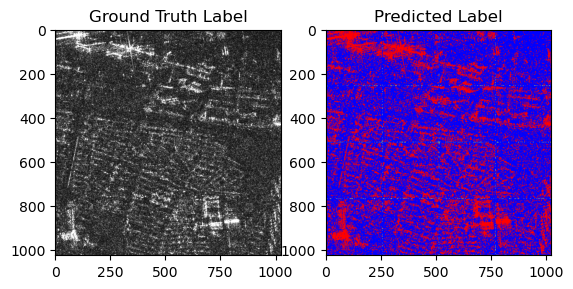

In [17]:
test_pred_mask = test_segmented_mask_plot(test_pred_labels, test_images)

In [22]:
# save the test mask
def save_mask(pred_mask, img_files):

    # Save folder for masks
    # Create a folder to save the images if it doesn't exist
    output_folder = data_dir + 'testImagesOutput/'
    os.makedirs(output_folder, exist_ok = True)
    print('Predicted image labels will be saved in directory : ', output_folder)
    
    for i, img_name in tqdm(enumerate(img_files)):
        # Save as image .png
        label_img = pred_mask[i]
        # Create a PIL image from the predicted labels
        img = Image.fromarray(label_img.astype(np.uint8))
    
        fname = os.path.join(output_folder, img_name)
        
        # Save the image as PNG
        img.save(fname)

    print('Successfully Saved the mask !!')

In [23]:
save_mask(test_pred_mask, test_img_files)

Predicted image labels will be saved in directory :  ./assignment3DataUpload/testImagesOutput/


10it [00:00, 411.36it/s]

Successfully Saved the mask !!
